In [1]:
import os
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


seed = 211
np.random.seed(seed)
torch.manual_seed(seed)


In [2]:
# Lebels definition
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
# The size of the window for 1 segment
window_size = 100
# The step size between 2 different windows
step_size = 40

In [3]:
# Specify the file path of the text file
text_file_path = "/home/ystolero/Documents/DL_technion/data//WISDM_ar_v1.1_raw.txt"

column_names = ['user-id','activity','timestamp','x-axis','y-axis','z-axis']

# Read the text file as a CSV file using pandas
df = pd.read_csv(text_file_path, header=None, names=column_names)

# Remove trailing ';' from a specific column
df['z-axis'] = df['z-axis'].str.rstrip(';')
df['z-axis'] = np.float64(df['z-axis'])

print(df.head())

   user-id activity       timestamp    x-axis     y-axis    z-axis
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098209 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098209 non-null  int64  
 1   activity   1098209 non-null  object 
 2   timestamp  1098209 non-null  int64  
 3   x-axis     1098209 non-null  float64
 4   y-axis     1098209 non-null  float64
 5   z-axis     1098208 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [5]:
# drop nans
df = df.dropna()

# drop rows where timestamp is zero
df = df[df['timestamp'] != 0]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085363 entries, 0 to 1098208
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1085363 non-null  int64  
 1   activity   1085363 non-null  object 
 2   timestamp  1085363 non-null  int64  
 3   x-axis     1085363 non-null  float64
 4   y-axis     1085363 non-null  float64
 5   z-axis     1085363 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB


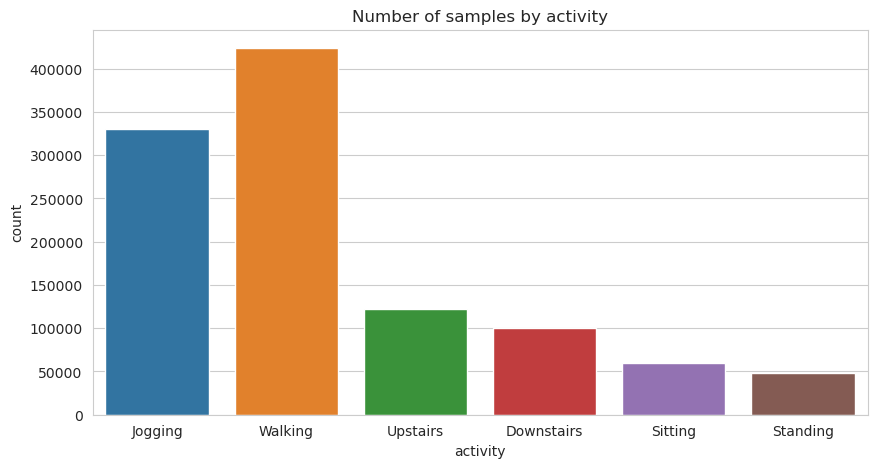

In [7]:
# Show how many training examples exist for each of the six activities
sns.set_style("whitegrid")
plt.figure(figsize = (10, 5))
sns.countplot( data = df, x = "activity")
plt.title("Number of samples by activity")
plt.show()

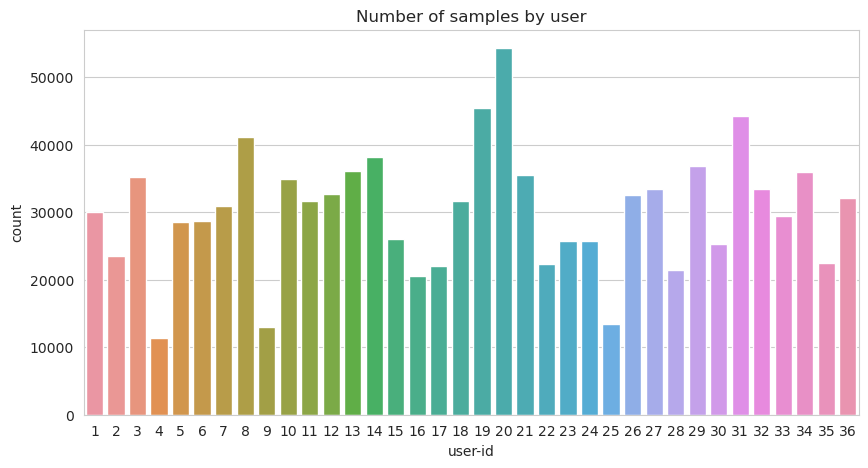

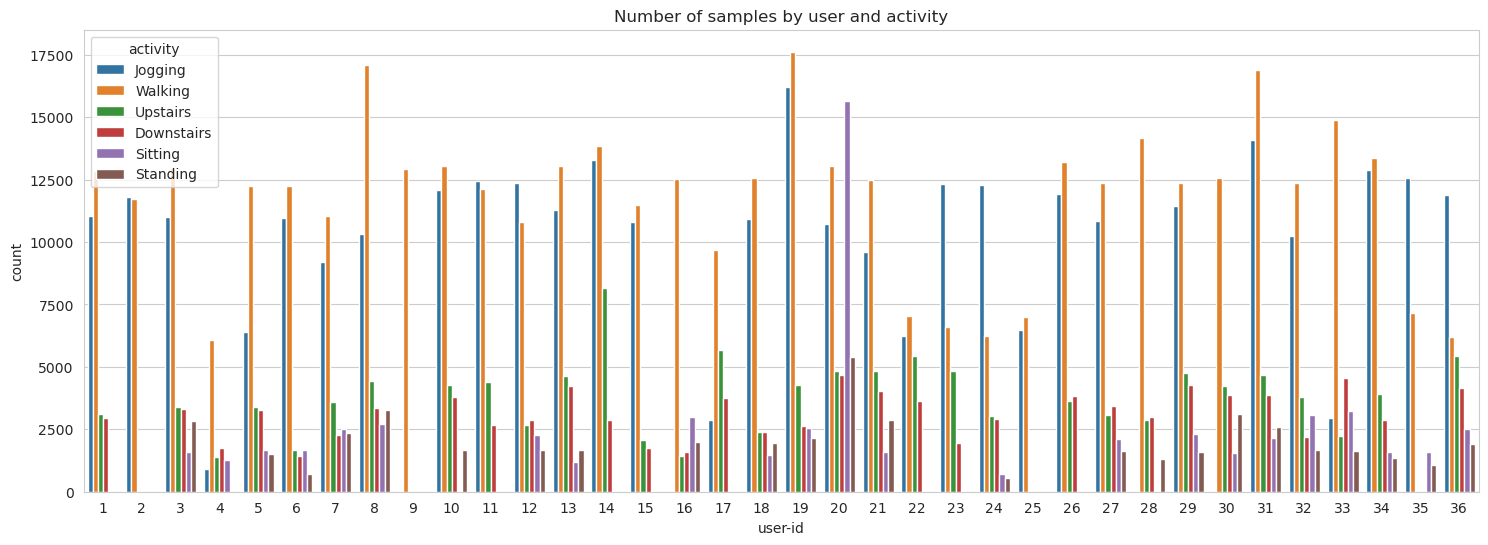

In [8]:
# Show the spread of activities by user

sns.set_style("whitegrid")
plt.figure(figsize = (10, 5))
sns.countplot( data = df, x = "user-id")
plt.title("Number of samples by user")
plt.show()


plt.figure(figsize = (18, 6))
sns.countplot(data = df, x ="user-id", hue = "activity" )
plt.title("Number of samples by user and activity")
plt.show()


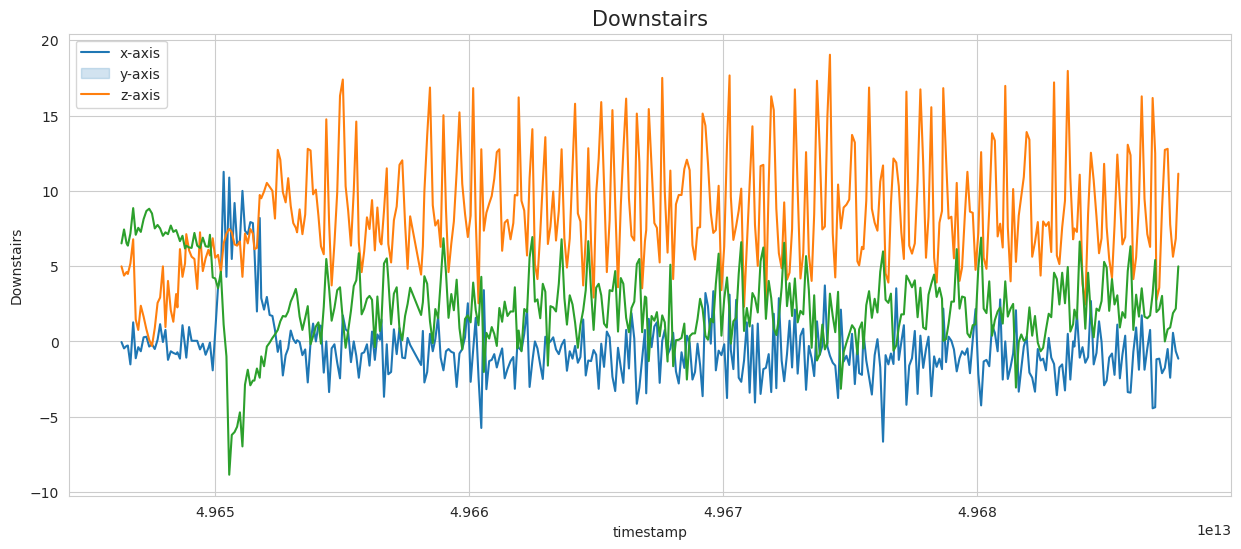

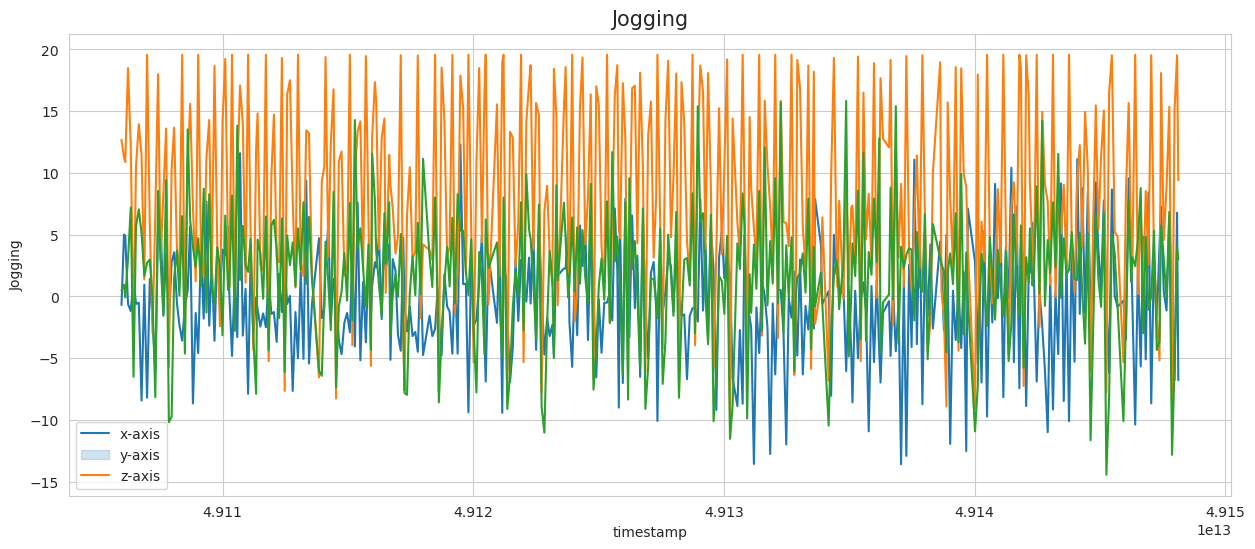

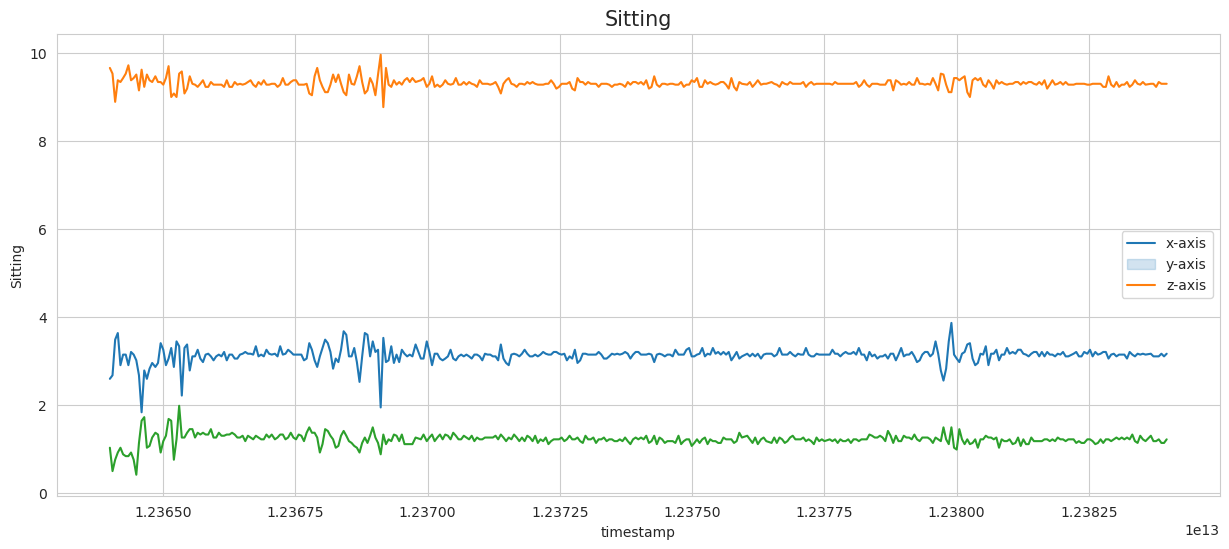

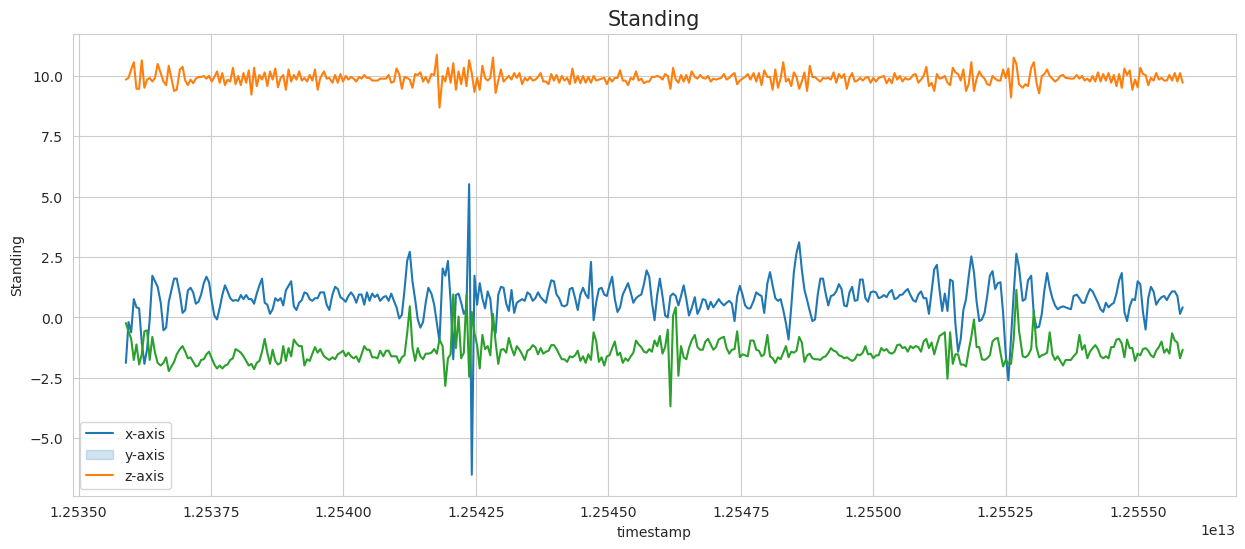

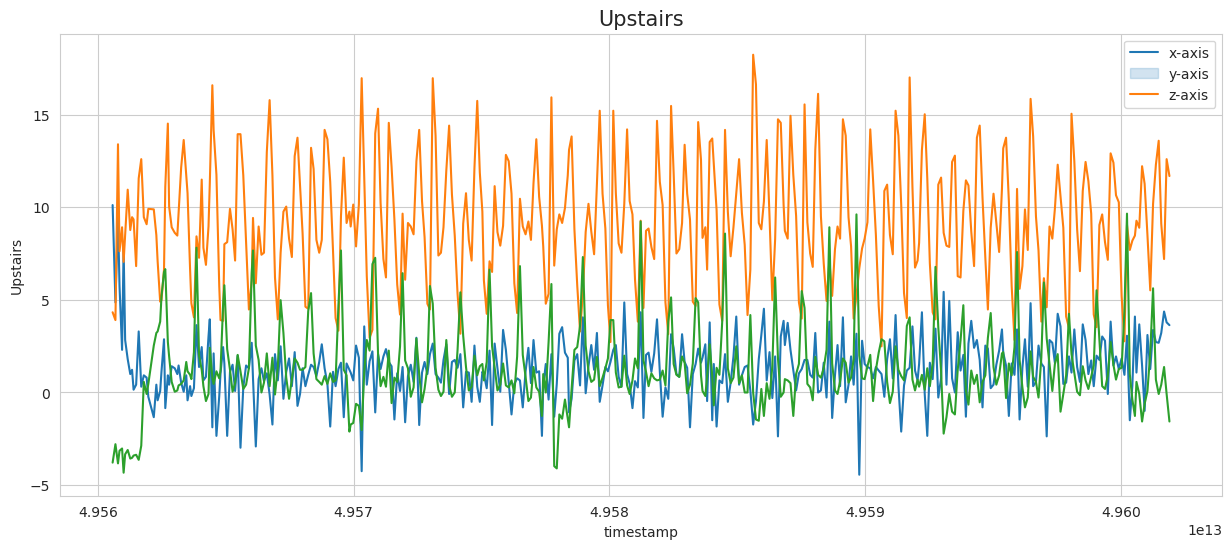

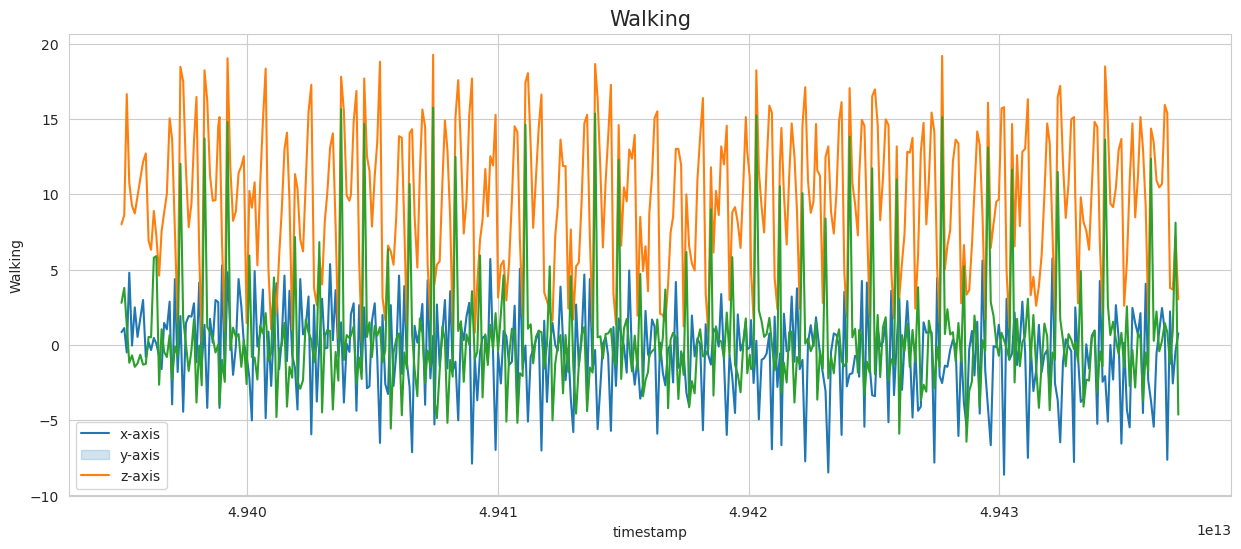

In [9]:
# Plot some activity examples

for activity in np.unique(df['activity']):
  subset = df[df['activity'] == activity][:400]
  plt.figure(figsize = (15, 6))
  sns.lineplot(data = subset,x = "timestamp" ,y = "x-axis" )
  sns.lineplot(data = subset,x = "timestamp" ,y = "y-axis" )
  sns.lineplot(data = subset,x = "timestamp" ,y = "z-axis" )
  plt.legend([ "x-axis",  "y-axis",  "z-axis"])
  plt.ylabel(activity)
  plt.title(activity, fontsize = 15)
  plt.show()

In [10]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()

# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())


In [11]:
set(df.ActivityEncoded)

{0, 1, 2, 3, 4, 5}

In [12]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 25]
df_train = df[df['user-id'] <= 25]

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738325 entries, 8489 to 1098208
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user-id          738325 non-null  int64  
 1   activity         738325 non-null  object 
 2   timestamp        738325 non-null  int64  
 3   x-axis           738325 non-null  float64
 4   y-axis           738325 non-null  float64
 5   z-axis           738325 non-null  float64
 6   ActivityEncoded  738325 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 45.1+ MB


In [13]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [14]:
x_train, y_train = create_segments_and_labels(df_train, window_size, step_size, LABEL)
x_test, y_test = create_segments_and_labels(df_test, window_size, step_size, LABEL)


/tmp/ipykernel_468868/2384245451.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df[label_name][i: i + time_steps])[0][0]


In [15]:
# Set input & output dimensions
num_sensors =  x_train.shape[2]
num_classes = le.classes_.size

In [16]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [17]:
# Convert your data to the appropriate format

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()


# One-hot encode the target labels
num_classes = 6
y_train_hot = F.one_hot(y_train, num_classes=num_classes).float()
y_test_hot = F.one_hot(y_test, num_classes=num_classes).float()

In [18]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_hot, test_size=0.2, random_state=seed)

In [19]:
# Create DataLoader objects for batching
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test_hot)


In [20]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_units, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_units, num_layers , batch_first=True)

        
        leack_slope = 0.05
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(hidden_units, 128),
            nn.LeakyReLU(negative_slope=leack_slope ,inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope=leack_slope ,inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slope=leack_slope ,inplace=True),
            nn.Linear(32, output_size)
        )

    def forward(self, x):

        h =  torch.zeros(self.num_layers, x.size(0), self.hidden_units).to(device)
        x,_ = self.gru(x, h)
        x = self.fc_layer(x[:, -1, :])

        return x

In [21]:
def calculate_accuracy(mode, dataloader, device):
    model.eval() # put in evaluation mode
    total_accuracy = []
    tot_labels = []
    tot_outputs = []
    confusion_matrix = np.zeros([6,6], int)
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            total_accuracy.append(metrics.accuracy_score(labels.cpu().argmax(dim=1).detach().numpy(), outputs.cpu().argmax(dim=1).detach().numpy()))
            for i, l in enumerate(labels):
                confusion_matrix[l.cpu().argmax().item(), outputs.cpu().argmax(dim=1).detach().numpy()[i].item()] += 1
    total_accuracy = np.mean(total_accuracy)
    return total_accuracy * 100, confusion_matrix

In [22]:
#hyper-parameters

batch_size = 256
learning_rate = 0.001
epochs = 30
hidden_size = 128
num_layers = 6

#dataloaders - creating batches and shuffling the data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


#device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#loss criterion
criterion = nn.CrossEntropyLoss()

#Create an instance of the model
input_channels = x_train.shape[2]

#Create an instance of the model
model = GRUModel(input_channels, hidden_size, num_layers, num_classes).to(device)


#optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
train_losses = []
val_losses = []
#Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_time = time.time()

    for i, data in enumerate(train_loader, 0):
        #get the inputs
        inputs, labels = data
        #send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        #forward + backward + optimize
        outputs = model(inputs)  # forward pass
        #print(outputs.argmax(dim = 1).float().shape, labels.shape)
        loss = criterion(outputs, labels)  # calculate the loss
        #always the same 3 steps
        optimizer.zero_grad()  # zero the parameter gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        #print statistics
        running_loss += loss.data.item()


    #Normalizing the loss by the total number of train batches
    running_loss /= len(train_loader)
    train_losses.append(running_loss)

    #Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0




    with torch.no_grad():
      for i, data in enumerate(val_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        val_loss += criterion(outputs, labels).data.item()


    val_loss /= len(val_loader)
    val_losses.append(val_loss)


    #Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, train_loader, device)
    val_accuracy, _ = calculate_accuracy(model, val_loader, device)

    log = "Epoch: {} | Train Loss: {:.4f} | Val Loss: {:.4f} | Training accuracy: {:.3f}% | Validation accuracy: {:.3f}% |".format(epoch, running_loss, val_loss, train_accuracy, val_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    #save model
    if epoch % 5 == 0:
        print('==> Saving model ...')
        state = {
            'net': model.state_dict(),
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, './checkpoints/gru_ckpt.pth')
print('==> Finished Training ...')

Epoch: 0 | Train Loss: 1.2991 | Val Loss: 0.8509 | Training accuracy: 72.085% | Validation accuracy: 72.563% |Epoch Time: 1.86 secs
==> Saving model ...
Epoch: 1 | Train Loss: 0.7600 | Val Loss: 0.6368 | Training accuracy: 78.814% | Validation accuracy: 79.531% |Epoch Time: 1.00 secs
Epoch: 2 | Train Loss: 0.6279 | Val Loss: 0.5609 | Training accuracy: 81.293% | Validation accuracy: 81.774% |Epoch Time: 1.43 secs
Epoch: 3 | Train Loss: 0.5560 | Val Loss: 0.5182 | Training accuracy: 82.077% | Validation accuracy: 82.434% |Epoch Time: 1.72 secs
Epoch: 4 | Train Loss: 0.5102 | Val Loss: 0.4657 | Training accuracy: 83.535% | Validation accuracy: 83.742% |Epoch Time: 1.52 secs
Epoch: 5 | Train Loss: 0.4837 | Val Loss: 0.4172 | Training accuracy: 83.492% | Validation accuracy: 83.596% |Epoch Time: 1.45 secs
==> Saving model ...
Epoch: 6 | Train Loss: 0.3870 | Val Loss: 0.3906 | Training accuracy: 86.411% | Validation accuracy: 86.255% |Epoch Time: 1.66 secs
Epoch: 7 | Train Loss: 0.3318 | Va

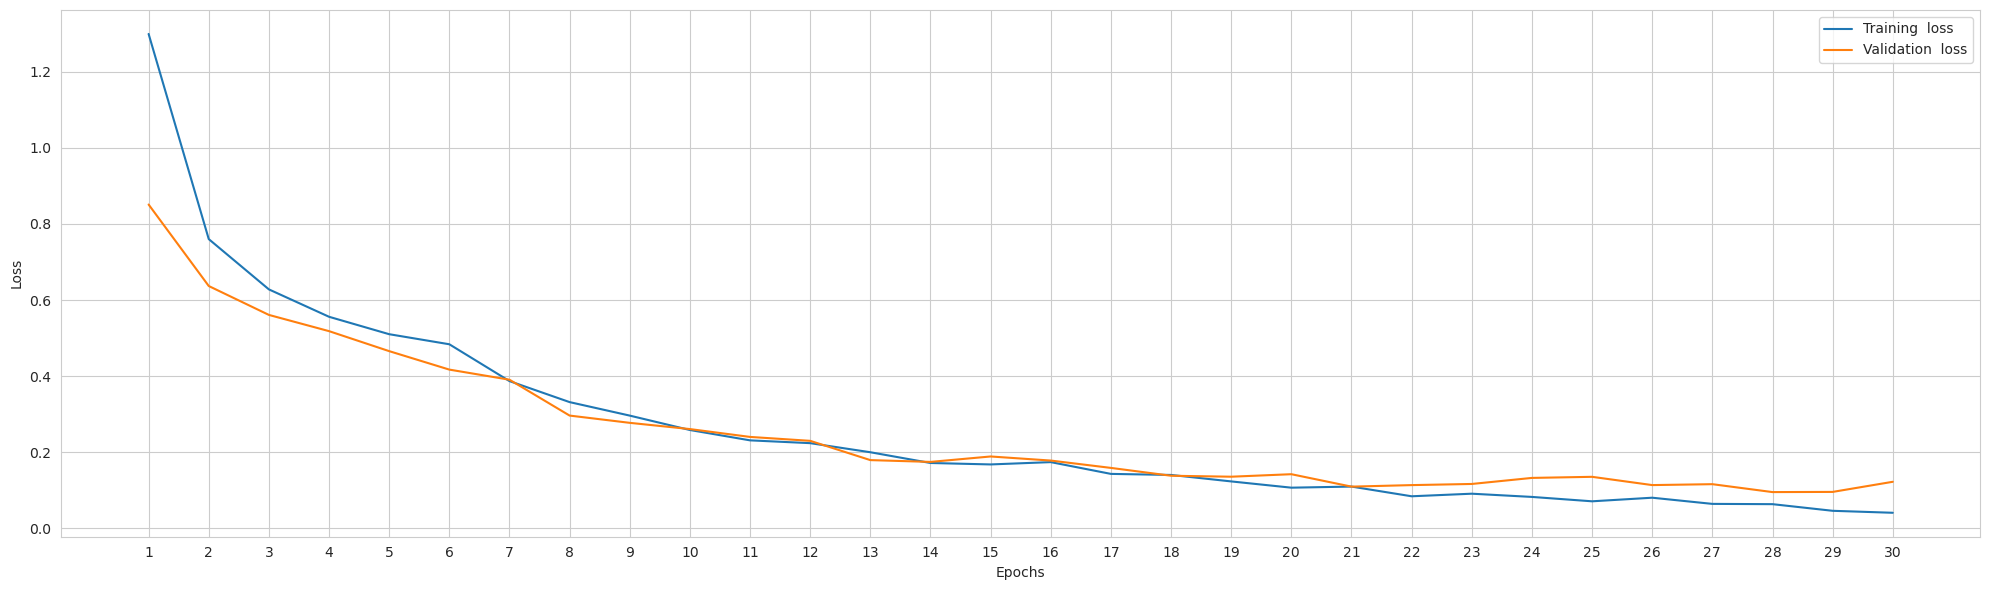

In [24]:

# plot the loss curves
x_epoch = list(range(1, epochs+1))
plt.figure(figsize=(20, 6))  # Specify width and height in inches
plt.plot(x_epoch, train_losses, label='Training  loss')
plt.plot(x_epoch, val_losses, label='Validation  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(x_epoch)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


test accuracy: 87.787%


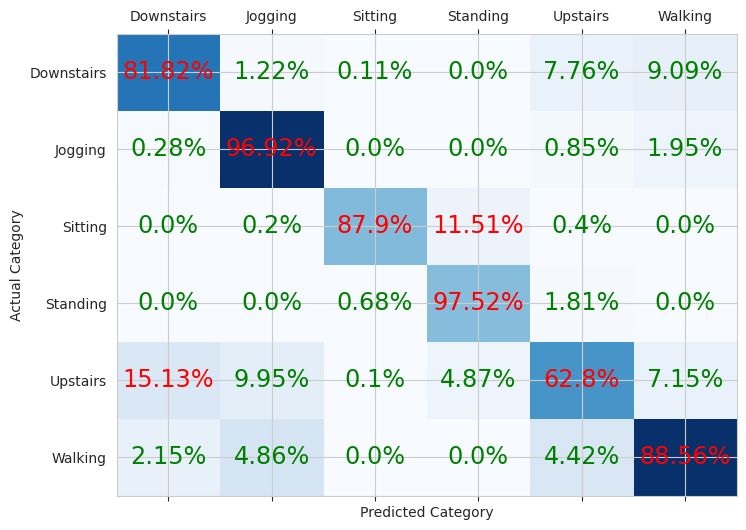

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       902
           1       0.90      0.97      0.93      2467
           2       0.99      0.88      0.93       504
           3       0.80      0.98      0.88       443
           4       0.71      0.63      0.67       965
           5       0.94      0.89      0.91      3393

    accuracy                           0.88      8674
   macro avg       0.85      0.86      0.85      8674
weighted avg       0.88      0.88      0.88      8674



In [25]:
device = 'cpu'
model = GRUModel(input_channels, hidden_size, num_layers, num_classes).to(device)
state = torch.load('/home/ystolero/Documents/DL_technion/gru/checkpoints/gru_ckpt.pth', map_location=device)
model.load_state_dict(state['net'])

test_accuracy, confusion_matrix = calculate_accuracy(model, test_loader, device)
print("test accuracy: {:.3f}%".format(test_accuracy))



y_pred = model(x_test.to(device))
y_pred = y_pred.cpu().argmax(dim=1).detach().numpy()



classes = LABELS

labels_sum = np.sum(y_test_hot.numpy(), axis=0)

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        if confusion_matrix[i, j] / labels_sum[i] * 100 > 10:
            ax.text(x=j, y=i,s=str(np.round(confusion_matrix[i, j] / labels_sum[i] * 100, decimals = 2)) + "%", va='center', ha='center', size='xx-large', color='red')
        else:
            ax.text(x=j, y=i,s=str(np.round(confusion_matrix[i, j] / labels_sum[i] * 100, decimals = 2)) + "%", va='center', ha='center', size='xx-large', color='green')
plt.ylabel('Actual Category')
plt.yticks(range(6), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(6), classes)
plt.show()


print(classification_report(y_test, y_pred))